In [63]:
#import all required packages
import os
import numpy as np
import matplotlib.pyplot as plt

from astropy.convolution import Gaussian2DKernel
from astropy.stats import gaussian_fwhm_to_sigma
from astropy.visualization import SqrtStretch, simple_norm
from astropy.visualization.mpl_normalize import ImageNormalize
from astropy.io import fits,ascii
from astropy.wcs import WCS
from astropy import units as u
from astropy.stats import sigma_clipped_stats
from astropy.table import join

from photutils.aperture import SkyCircularAperture,SkyCircularAnnulus,aperture_photometry 
from photutils.segmentation import detect_threshold, detect_sources, deblend_sources, SourceCatalog
from photutils.background import Background2D, MedianBackground, SExtractorBackground, MMMBackground
from photutils.utils import calc_total_error

In [64]:
#data path
dpath='C:/Users/mhankins1/Documents/SofiaLegacyProgram/SOFIA_Cycle7_Data/SgrAandNearby'
dpathalt='E:\Documents\SofiaLegacyProgram\CAL_files\CAL_C'

#file name
fname='F0591_FO_IMA_07018913_FORF253_CAL_0088-0114_Field_B.fits'

#Name of field
field='FieldB'

#wavelength of data
wavelength=25.2

In [65]:
#change directory to data location
try:
    os.chdir(dpath)
except:
    os.chdir(dpathalt)

#import data - unpack fits file into header, image (data), varance (varmap), and exposure time (tmap)
hdu=fits.open(fname)
header=hdu[0].header
ims=hdu[0].data
#np.shape(ims)
data=ims[0]
varmap=ims[1]
tmap=ims[2]
#wcsmap = WCS(header)
hdu.close()

#hack to make SOFIA wcs header work correctly with astropy.wcs
hdu[0].header['NAXIS']=2
wcsmap=WCS(hdu[0].header)

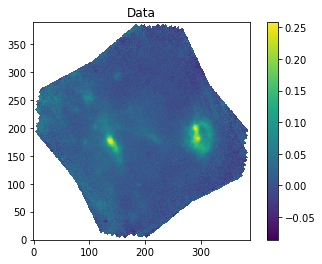

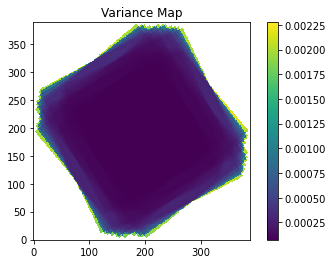

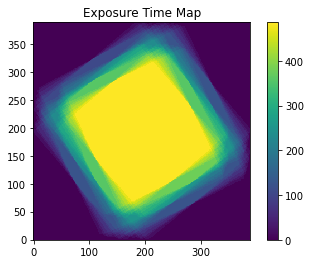

In [66]:
#take a quick look at the maps that were loaded in 
plt.figure()
plt.title('Data')
plt.imshow(data,origin='lower',interpolation='none')
plt.colorbar()
#plt.clim(0.0,0.1)
plt.show()

plt.figure()
plt.title('Variance Map')
plt.imshow(varmap,origin='lower',interpolation='none')
plt.colorbar()
plt.show()

plt.figure()
plt.title('Exposure Time Map')
plt.imshow(tmap,origin='lower',interpolation='none')
plt.colorbar()
plt.show()

#create pixel error map by taking sqrt of variance map
errormap=np.sqrt(varmap)

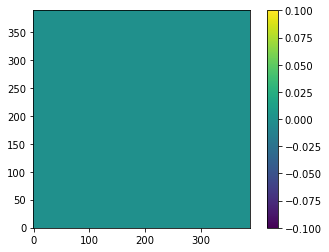

In [67]:
#create mask for edges of field where less integration time was collected
tmapnorm=tmap/np.max(tmap) #normalize the exposure time map
mask=np.where(tmapnorm<0.5,tmapnorm,0).astype('bool') #create mask for any locations with less than 50% of max exposure time -Can be modified as needed

#additional series of masks that can be applied when searching for sources in the segmentation map
mask2=np.zeros(np.shape(mask))  #mask 2 is applied to the first segmentation map instance for source detection
#mask2[0:100,0:250]=1

mask3=np.zeros(np.shape(mask))  #mask 3 is applied to the deblended segmentation map for source detection - this may or may not be needed if the first 2 masks work ok
#mask3[0:330,0:70]=1

#plot any of the masks to verify they are configured as needed
plt.figure()
plt.imshow(mask2,origin='lower',interpolation='none')
plt.colorbar()
plt.show()

In [68]:
#create background model for image using median method
bkg_estimator = MedianBackground()
bkg_data = Background2D(data,(20, 20), filter_size=(3, 3),bkg_estimator=bkg_estimator,edge_method='pad') #smaller box?, 20x20, 25x25?
bkg_rms=bkg_data.background_rms
bkg=bkg_data.background 

#create background subtracted image
data_bkgsub = data - bkg

#set detection threshold for source finding based on modeled background rms
threshold = 3.0*bkg_rms

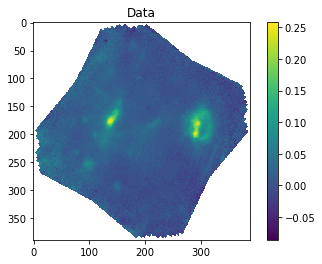

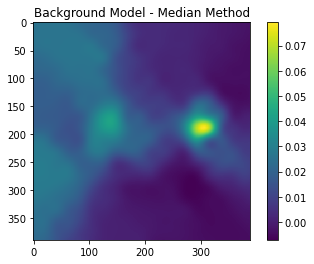

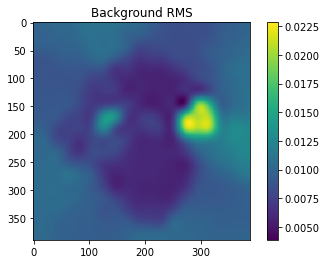

In [69]:
#take a look at data and bakground model images
plt.figure()
plt.title('Data')
plt.imshow(data,interpolation='none')
plt.colorbar()
plt.show()

plt.figure()
plt.title('Background Model - Median Method')
plt.imshow(bkg,interpolation='none')
plt.colorbar()
plt.show()

plt.figure()
plt.title('Background RMS')
plt.imshow(bkg_rms,interpolation='none')
plt.colorbar()
plt.show()

In [70]:
#do source detection. A 3x3 FWHM gaussian is used to smooth image prior to detection
sigma = 3.0 * gaussian_fwhm_to_sigma  # FWHM = 3.
kernel = Gaussian2DKernel(sigma, x_size=3, y_size=3)
kernel.normalize()
segm = detect_sources(data_bkgsub, threshold, mask=mask, npixels=5, filter_kernel=kernel)

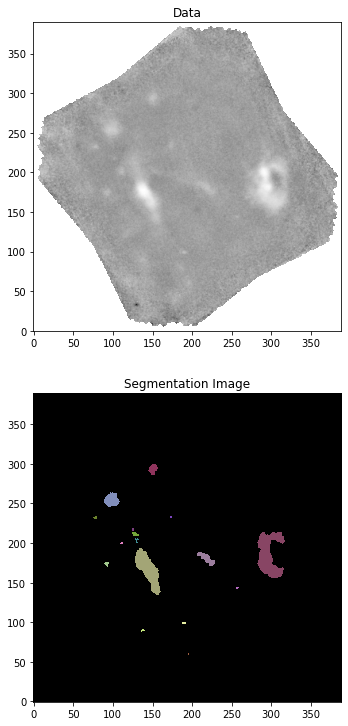

In [71]:
#removed labels that exist in masked region (mask2)
segm.remove_masked_labels(mask2.astype('bool'))

#make plot of segmentation image to show detected sources
norm = ImageNormalize(stretch=SqrtStretch())
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 12.5))
ax1.imshow(data_bkgsub, origin='lower', cmap='Greys_r', norm=norm)
ax1.set_title('Data')
cmap = segm.make_cmap(seed=123)
ax2.imshow(segm, origin='lower', cmap=cmap, interpolation='nearest')
ax2.set_title('Segmentation Image')
plt.show()

In [72]:
#now lets look at building a catalog and associated table from the seg map
cat = SourceCatalog(data_bkgsub, segm,background=bkg,wcs=wcsmap) #can also take in error and bkg measurements - this is done later

#specify the columns that we want for our table
columns=['label','xcentroid','ycentroid','sky_centroid','background_centroid', 'background_mean','background_sum','area',
         'semimajor_sigma','semiminor_sigma','orientation', 'cxx','cxy','cyy','eccentricity','ellipticity','elongation',
         'fwhm','kron_flux','kron_fluxerr','kron_radius','segment_flux','segment_fluxerr']

#create table
tbl = cat.to_table(columns)

#display table below
tbl

label,xcentroid,ycentroid,sky_centroid,background_centroid,background_mean,background_sum,area,semimajor_sigma,semiminor_sigma,orientation,cxx,cxy,cyy,eccentricity,ellipticity,elongation,fwhm,kron_flux,kron_fluxerr,kron_radius,segment_flux,segment_fluxerr
,,,"deg,deg",,,,pix2,pix,pix,deg,1 / pix2,1 / pix2,1 / pix2,,,,pix,,,pix,,
int32,float64,float64,object,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64
1,195.7492464873999,60.2201194393198,"266.3437830352442,-29.000640266530365",0.014447981976944057,0.004911814984458538,0.0392945198756683,8.0,0.9520126397894663,0.6547926574896064,82.46178151710728,2.311191781096414,-0.31966934572445593,1.1245043378382755,0.7259018695007106,0.3122017186301107,1.453914653593344,1.923962547496037,1.6110809642611188,nan,3.488377744660649,0.21537844329652905,nan
2,138.09152783560853,89.66108596783418,"266.35784556720984,-28.99435826218936",0.023351931998442186,0.017682542392942997,0.26523813589414497,15.0,1.5326483401094806,0.8535548418993981,1.924073443038364,0.4267784795306716,-0.06354648711772493,1.3715109426102083,0.8305694967330086,0.44308500550202745,1.795606169486321,2.9211003078884206,2.6205230767728085,nan,3.3861264253768675,0.3993564696709261,nan
3,189.7978711731326,98.90799829478321,"266.34523415120753,-28.992386791382273",0.025341185337836507,0.005909364481540165,0.08273110274156231,14.0,1.293127641800095,0.7583754872121593,-4.357204674668606,0.6046063217636073,0.17282755107311412,1.7321428566606767,0.8099737944682635,0.41353392913597864,1.7051284800273827,2.4961717149907057,0.7635169849930652,nan,1.9599834183229305,0.405889925398625,nan
4,142.50823511288576,170.01665323057722,"266.3567653205225,-28.97721589239578",0.015880080977603957,0.03581923348668399,31.70002163571533,885.0,12.890032296031253,4.212675646154373,-61.89756313604681,0.04518107292444611,0.041825959036416206,0.017186185808749,0.9450878026543433,0.6731834684811904,3.059820735972916,22.58047541973804,92.74547385922418,nan,1.6209389986665863,70.9783655852336,nan
5,256.67850220229053,143.59743846535514,"266.32892302470225,-28.9828528563217",0.0065643527219051345,0.005245085929735522,0.02622542964867761,5.0,0.6993456360345756,0.47178031202899284,15.032841062414168,2.209337635814022,-1.226528123539927,4.328133588458039,0.7381811915997882,0.3253975034375305,1.4823544310844363,1.4046861611230832,0.4006142478509582,nan,3.0891959429458447,0.10913697754391023,nan
6,295.51569717962434,184.57987221292615,"266.3194532224743,-28.9741089248829",-0.0025205874300713383,0.04575661593399107,53.169187715297625,1162.0,16.130683591495146,7.550963620919175,-84.16313242555461,0.017396972850231247,0.002771105182032022,0.003984853108949944,0.8836692400938874,0.5318881820420557,2.136241730367596,29.65652571084007,160.05121877926706,nan,1.2915568812688416,105.19379494150908,nan
7,92.82900760462934,174.13619748794247,"266.3688799275214,-28.97633488969465",0.008268612238091617,0.020679540845989837,0.5790271436877155,28.0,1.5889876439429722,1.5313292736933077,-89.6852838361061,0.426443890410145,0.00033381091655282726,0.3960590715522231,0.26693776140218944,0.0362862294552454,1.037652496585925,3.6745195842832663,1.976552465565337,nan,2.4047923279438232,0.7380473079078295,nan
8,217.74043278467232,180.66838914558073,"266.33841906674195,-28.974944736415083",0.021557533149261055,0.013697824467953033,2.43821275529564,178.0,6.546448079078307,2.1725342637805003,-36.25074471338465,0.08925691347292637,0.17981021313655335,0.14594571702485337,0.9433270368006083,0.6681354167119007,3.0132772533062893,11.48513688874035,16.67405981704312,nan,2.9365108952405037,5.228890287530417,nan


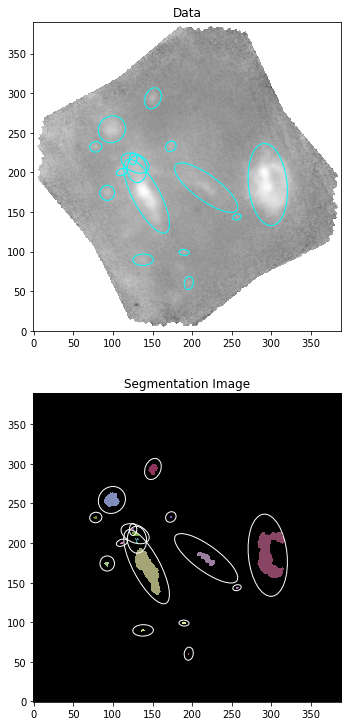

In [73]:
#overplot catalog sources on image - Note some sources may not have apertures plotted if kron aperture fails, but that's ok
norm = simple_norm(data, 'sqrt')
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 12.5))
ax1.imshow(data, origin='lower', cmap='Greys_r', norm=norm)
ax1.set_title('Data')
cmap = segm.make_cmap(seed=123)
ax2.imshow(segm, origin='lower', cmap=cmap,interpolation='nearest')
ax2.set_title('Segmentation Image')
#try-except logic to catch any instances where kron aperture does something weird
for aperture in cat.kron_aperture:
    try:
        aperture.plot(axes=ax1, color='cyan', lw=1.)
        aperture.plot(axes=ax2, color='white', lw=1.)
    except:
        skip=1
plt.show()

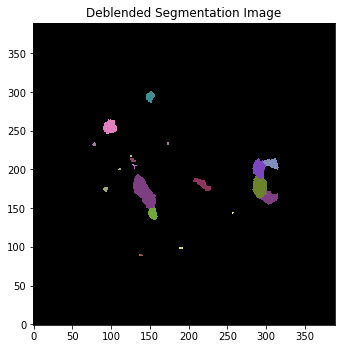

In [74]:
#lets take a look at deblending sources
segm_deblend = deblend_sources(data_bkgsub, segm, npixels=5,filter_kernel=kernel, nlevels=64,contrast=0.001)

#remove any sources that should be masked (mask3)
segm_deblend.remove_masked_labels(mask3.astype('bool'))

#plot the deblended image
plt.figure(figsize=(5.4, 8.5))
plt.imshow(segm_deblend, origin='lower', cmap=cmap, interpolation='nearest')
plt.title('Deblended Segmentation Image')
plt.show()

In [75]:
#now lets look at building a catalog and table from the deblended seg map
catde = SourceCatalog(data_bkgsub, segm_deblend,background=bkg,wcs=wcsmap)

#define which columns we want to have in the table
columns=['label','xcentroid','ycentroid','sky_centroid','background_centroid', 'background_mean','background_sum','area',
         'semimajor_sigma','semiminor_sigma','orientation', 'cxx','cxy','cyy','eccentricity','ellipticity','elongation',
         'fwhm','kron_flux','kron_fluxerr','kron_radius','segment_flux','segment_fluxerr']

#create table
tbl_deblend = catde.to_table(columns)

#display table
tbl_deblend

label,xcentroid,ycentroid,sky_centroid,background_centroid,background_mean,background_sum,area,semimajor_sigma,semiminor_sigma,orientation,cxx,cxy,cyy,eccentricity,ellipticity,elongation,fwhm,kron_flux,kron_fluxerr,kron_radius,segment_flux,segment_fluxerr
,,,"deg,deg",,,,pix2,pix,pix,deg,1 / pix2,1 / pix2,1 / pix2,,,,pix,,,pix,,
int32,float64,float64,object,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64
1,195.7492464873999,60.2201194393198,"266.3437830352442,-29.000640266530365",0.014447981976944057,0.004911814984458538,0.0392945198756683,8.0,0.9520126397894663,0.6547926574896064,82.46178151710728,2.311191781096414,-0.31966934572445593,1.1245043378382755,0.7259018695007106,0.3122017186301107,1.453914653593344,1.923962547496037,1.6110809642611188,nan,3.488377744660649,0.21537844329652905,nan
2,138.09152783560853,89.66108596783418,"266.35784556720984,-28.99435826218936",0.023351931998442186,0.017682542392942997,0.26523813589414497,15.0,1.5326483401094806,0.8535548418993981,1.924073443038364,0.4267784795306716,-0.06354648711772493,1.3715109426102083,0.8305694967330086,0.44308500550202745,1.795606169486321,2.9211003078884206,2.6205230767728085,nan,3.3861264253768675,0.3993564696709261,nan
3,189.7978711731326,98.90799829478321,"266.34523415120753,-28.992386791382273",0.025341185337836507,0.005909364481540165,0.08273110274156231,14.0,1.293127641800095,0.7583754872121593,-4.357204674668606,0.6046063217636073,0.17282755107311412,1.7321428566606767,0.8099737944682635,0.41353392913597864,1.7051284800273827,2.4961717149907057,0.7635169849930652,nan,1.9599834183229305,0.405889925398625,nan
4,256.67850220229053,143.59743846535514,"266.32892302470225,-28.9828528563217",0.0065643527219051345,0.005245085929735522,0.02622542964867761,5.0,0.6993456360345756,0.47178031202899284,15.032841062414168,2.209337635814022,-1.226528123539927,4.328133588458039,0.7381811915997882,0.3253975034375305,1.4823544310844363,1.4046861611230832,0.4006142478509582,nan,3.0891959429458447,0.10913697754391023,nan
5,92.82900760462934,174.13619748794247,"266.3688799275214,-28.97633488969465",0.008268612238091617,0.020679540845989837,0.5790271436877155,28.0,1.5889876439429722,1.5313292736933077,-89.6852838361061,0.426443890410145,0.00033381091655282726,0.3960590715522231,0.26693776140218944,0.0362862294552454,1.037652496585925,3.6745195842832663,1.976552465565337,nan,2.4047923279438232,0.7380473079078295,nan
6,111.21979056400754,200.4166740988525,"266.36439376224484,-28.970729317216065",0.0068280607361116425,0.031752295384740135,0.15876147692370068,5.0,0.7652800391832192,0.44518234779540367,19.89499074522939,2.0940696520438964,-2.1363895522377425,4.659155925563836,0.8133857034557709,0.4182752391261305,1.7190260192772189,1.4742009129306026,1.4596981680405665,nan,3.7728434028678435,0.16460686753225673,nan
7,130.3359843235799,204.10703380467342,"266.35973218526004,-28.969942847905628",0.007336737259306187,0.03312802596101007,0.43066433749313093,13.0,1.7622395206589898,1.2586692996104514,-85.93659648828884,0.6296615741559,0.04371038378607961,0.32356313826440924,0.6998966130767094,0.285755832362804,1.4000814361678557,3.6059271518317653,11.55201973153316,nan,3.8540947060996547,0.3929953283894565,nan
8,128.0468455616562,211.69527968252805,"266.3602900408925,-28.968323934010442",0.0064547251698064655,0.030271002876861755,0.9384010891827144,31.0,2.058150906876246,1.2277068427760005,-23.45466477690435,0.3037794104778405,0.31210513737498274,0.5957469233739497,0.8026059165976686,0.4034903666809594,1.6764188608923172,3.9904471042735885,8.981195918998107,nan,3.6389348042935916,0.8729817372349702,nan


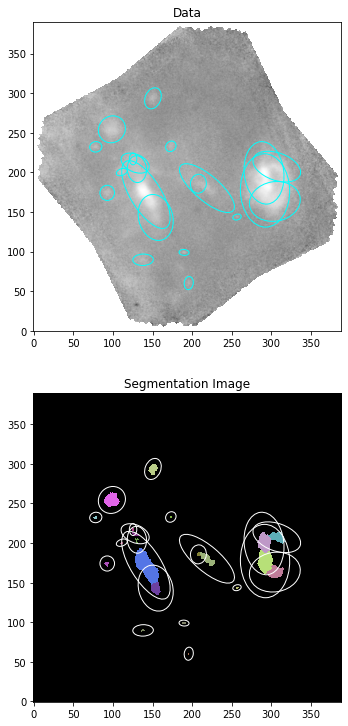

In [76]:
#overplot catalog sources on image - Note some sources may not have apertures plotted if kron aperture fails, but that's ok
norm = simple_norm(data, 'sqrt')
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 12.5))
ax1.imshow(data, origin='lower', cmap='Greys_r', norm=norm)
ax1.set_title('Data')
cmap = segm_deblend.make_cmap(seed=123)
ax2.imshow(segm_deblend, origin='lower', cmap=cmap,interpolation='nearest')
ax2.set_title('Segmentation Image')
#try-except logic to catch any instances where kron aperture does something weird
for aperture in catde.kron_aperture:
    try:
        aperture.plot(axes=ax1, color='cyan', lw=1.)
        aperture.plot(axes=ax2, color='white', lw=1.)
    except:
        skip=1
plt.show()

In [77]:
#what if we wanted to include errors? - Not completely sure this is implemented correctly for our observations, but we'll use it for now...
calfactor = header['CALFCTR'] # units are (Me/sec/Jy)
gainfactor=tmap*calfactor*1e6 #gain in electrons/Jy
#errormap=calc_total_error(data,bkg,gainfactor) #use the varmap instead. Its probably more appropriate for our data type. 

#now lets look at building a catalog from the seg map
catwerr = SourceCatalog(data_bkgsub, segm_deblend,background=bkg,error=errormap,wcs=wcsmap)
columns=['label','xcentroid','ycentroid','sky_centroid','background_centroid', 'background_mean','background_sum','background','area',
         'semimajor_sigma','semiminor_sigma','orientation', 'cxx','cxy','cyy','eccentricity','ellipticity','elongation',
         'fwhm','kron_flux','kron_fluxerr','kron_radius','segment_flux','segment_fluxerr']#,'kron_aperture']
tbl2 = catwerr.to_table(columns)

In [78]:
#calculate statistics for background cutouts in table
segbkg_median=[]
segbkg_mean=[]
segbkg_std=[]

#loop through each cutout and use sigma_cliped_stats to get mean, median, and std
for i in range (0,len(tbl2['background'])):
    bkgdata=tbl2['background'][i]
    meansc, median_sigclip, stdsc = sigma_clipped_stats(bkgdata)
    segbkg_median.append(median_sigclip)
    segbkg_mean.append(meansc)
    segbkg_std.append(stdsc)

#add the above calculated information to our table
tbl2['segbkg_mean_sc']=segbkg_mean
tbl2['segbkg_median_sc']=segbkg_median
tbl2['segbkg_std_sc']=segbkg_std  

#remove the 2d background array to tidy up the table
tbl2.remove_column('background')

In [79]:
#calculate noise stats
#sky noise from background
skynoise=np.sqrt(tbl2['segbkg_median_sc']*tbl2['area']/u.pix**2)
#replace any nan values with zero
sna=np.array(skynoise)
masknan=np.isnan(sna)
sna[masknan]=0.0
skynoise=sna**2

#shot noise from the source
sourcenoise=tbl2['segment_flux']

#thermal noise from camera (from error map)
thermalnoise=tbl2['segment_fluxerr']

#total noise
#totalnoise=np.sqrt(sourcenoise+thermalnoise+skynoise) #includes all noise sources
totalnoise=np.sqrt(thermalnoise+skynoise) #no shot noise -> For some reason this seems to work much better for the apertures. Need to think about why this is a bit more...

#calculate SNR for the segments
tbl2['segmentSNR']=tbl2['segment_flux']/ totalnoise 

#display table
tbl2

label,xcentroid,ycentroid,sky_centroid,background_centroid,background_mean,background_sum,area,semimajor_sigma,semiminor_sigma,orientation,cxx,cxy,cyy,eccentricity,ellipticity,elongation,fwhm,kron_flux,kron_fluxerr,kron_radius,segment_flux,segment_fluxerr,segbkg_mean_sc,segbkg_median_sc,segbkg_std_sc,segmentSNR
,,,"deg,deg",,,,pix2,pix,pix,deg,1 / pix2,1 / pix2,1 / pix2,,,,pix,,,pix,,,,,,
int32,float64,float64,object,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float32,float64,float64,float64,float64
1,195.7492464873999,60.2201194393198,"266.3437830352442,-29.000640266530365",0.014447981976944057,0.004911814984458538,0.0392945198756683,8.0,0.9520126397894663,0.6547926574896064,82.46178151710728,2.311191781096414,-0.31966934572445593,1.1245043378382755,0.7259018695007106,0.3122017186301107,1.453914653593344,1.923962547496037,1.6110809642611188,0.12803008477129735,3.488377744660649,0.21537844329652905,0.02977844,0.00490654690078158,0.004893731541431371,0.0001341813699667503,0.8203581093078959
2,138.09152783560853,89.66108596783418,"266.35784556720984,-28.99435826218936",0.023351931998442186,0.017682542392942997,0.26523813589414497,15.0,1.5326483401094806,0.8535548418993981,1.924073443038364,0.4267784795306716,-0.06354648711772493,1.3715109426102083,0.8305694967330086,0.44308500550202745,1.795606169486321,2.9211003078884206,2.6205230767728085,0.17330150167530003,3.3861264253768675,0.3993564696709261,0.039453823,0.017540254348675975,0.0175394005246642,0.0005598544183286913,0.7260488733133605
3,189.7978711731326,98.90799829478321,"266.34523415120753,-28.992386791382273",0.025341185337836507,0.005909364481540165,0.08273110274156231,14.0,1.293127641800095,0.7583754872121593,-4.357204674668606,0.6046063217636073,0.17282755107311412,1.7321428566606767,0.8099737944682635,0.41353392913597864,1.7051284800273827,2.4961717149907057,0.7635169849930652,0.07633436458034255,1.9599834183229305,0.405889925398625,0.033222288,0.005906957716870041,0.005898212123681209,8.170430924820135e-05,1.1927766663689843
4,256.67850220229053,143.59743846535514,"266.32892302470225,-28.9828528563217",0.0065643527219051345,0.005245085929735522,0.02622542964867761,5.0,0.6993456360345756,0.47178031202899284,15.032841062414168,2.209337635814022,-1.226528123539927,4.328133588458039,0.7381811915997882,0.3253975034375305,1.4823544310844363,1.4046861611230832,0.4006142478509582,0.06952766562073713,3.0891959429458447,0.10913697754391023,0.01976625,0.005199292255814079,0.005201972916505203,0.00015574025012110224,0.5100966313172457
5,92.82900760462934,174.13619748794247,"266.3688799275214,-28.97633488969465",0.008268612238091617,0.020679540845989837,0.5790271436877155,28.0,1.5889876439429722,1.5313292736933077,-89.6852838361061,0.426443890410145,0.00033381091655282726,0.3960590715522231,0.26693776140218944,0.0362862294552454,1.037652496585925,3.6745195842832663,1.976552465565337,0.16203559160138836,2.4047923279438232,0.7380473079078295,0.052371908,0.02074741300775442,0.020690973600708616,0.001031222540360355,0.9285860879991505
6,111.21979056400754,200.4166740988525,"266.36439376224484,-28.970729317216065",0.0068280607361116425,0.031752295384740135,0.15876147692370068,5.0,0.7652800391832192,0.44518234779540367,19.89499074522939,2.0940696520438964,-2.1363895522377425,4.659155925563836,0.8133857034557709,0.4182752391261305,1.7190260192772189,1.4742009129306026,1.4596981680405665,0.08627218880929191,3.7728434028678435,0.16460686753225673,0.019788297,0.031680844405079074,0.03169031067860909,0.00026376267169800593,0.3898930968960065
7,130.3359843235799,204.10703380467342,"266.35973218526004,-28.969942847905628",0.007336737259306187,0.03312802596101007,0.43066433749313093,13.0,1.7622395206589898,1.2586692996104514,-85.93659648828884,0.6296615741559,0.04371038378607961,0.32356313826440924,0.6998966130767094,0.285755832362804,1.4000814361678557,3.6059271518317653,11.55201973153316,0.220

In [80]:
#now lets look at performing some aperture photometry on the data.... Lets get the source centroids from the segmentaion map table
sourcecoords=tbl2['sky_centroid']

In [81]:
#first let's do some simple annulus extractions...   
radii = [2,4,6,8,10] #define aperture radii & construct apertures (line below)
apertures =[SkyCircularAperture(sourcecoords, r=r*u.arcsec) for r in radii] # for pixels: r=r*u.arcsec*0.786

#do aperture photometry on data using defined apertures 
phot_table = aperture_photometry(data_bkgsub, apertures,wcs=wcsmap,error=errormap,method='exact')

#display phot table
phot_table

id,xcenter,ycenter,sky_center,aperture_sum_0,aperture_sum_err_0,aperture_sum_1,aperture_sum_err_1,aperture_sum_2,aperture_sum_err_2,aperture_sum_3,aperture_sum_err_3,aperture_sum_4,aperture_sum_err_4
,pix,pix,"deg,deg",,,,,,,,,,
int32,float64,float64,object,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64
1,195.7492464873443,60.220119439384206,"266.3437830352442,-29.000640266530365",0.4475379124900967,0.04854538168011553,1.1355285766712204,0.09687957168647711,1.831402701805457,0.14530304190019683,2.4509043837140547,0.19361711148193267,2.986032356126273,0.24194051382387324
2,138.09152783558554,89.66108596791624,"266.35784556720984,-28.99435826218936",0.49162170094266494,0.04701428286213735,1.3908290640101095,0.09362503874873249,2.4065553184868653,0.13992380149295483,3.2172028165593343,0.18642654792063137,3.8979428399093576,0.23417271360176278
3,189.7978711732189,98.90799829474082,"266.34523415120753,-28.992386791382273",0.5002878702120449,0.040978442733643795,0.7018875675410452,0.08192606831575497,0.5587437134476386,0.12286308487511072,-0.01365645724682607,0.16373756663117464,-0.3172278735212335,0.20456318790501352
4,256.678502202192,143.59743846540076,"266.32892302470225,-28.9828528563217",0.26886314551892154,0.04081970858844221,0.388327671273387,0.08161502616307773,0.31113542139035233,0.1223554223590928,0.24513588294075955,0.1630860758138975,0.0991943855585772,0.20379424577139385
5,92.82900760459651,174.1361974879395,"266.3688799275214,-28.97633488969465",0.5507672427155502,0.04576043010453586,1.5241783826975124,0.0910879555027258,1.955937951156962,0.1355112861081016,1.9364884852418227,0.1796227827757832,1.603963664756965,0.22409655760218464
6,111.21979056403407,200.41667409885466,"266.36439376224484,-28.970729317216065",0.5350812208733077,0.04081101040614957,1.43216786070491,0.08162762828256095,1.990982853720245,0.12243846253640704,2.157209985220173,0.16320770004335108,2.194443402179745,0.2039504539854357
7,130.335984323684,204.10703380467135,"266.35973218526004,-28.969942847905628",0.5901478738115566,0.040589933568754656,2.1340700800883217,0.08113556383051337,4.277604196238221,0.12170178874861433,6.963805555682433,0.16224539836947427,9.927596422562917,0.2028078203667969
8,128.04684556185987,211.69527968259484,"266.3602900408925,-28.968323934010442",0.6057071802668607,0.04062657214117911,2.0557200899404244,0.0812452589425896,4.211264238562924,0.12189709472127071,6.482762208800167,0.1625808932420929,8.89917560508653,0.20324093938583881


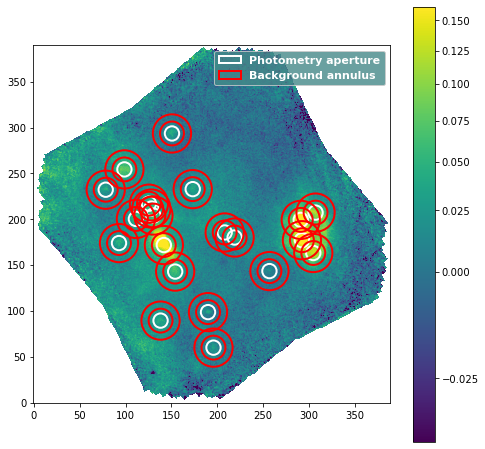

In [82]:
#now try photometry with local background subtraction
aperture2 =SkyCircularAperture(sourcecoords, r=6*u.arcsec) #define aperture
annulus_aperture = SkyCircularAnnulus(sourcecoords, r_in=10*u.arcsec, r_out=16*u.arcsec) #define annulus

#convert to pixel coords for plotting
pix_aperture = aperture2.to_pixel(wcsmap)
pix_annulus_aperture = annulus_aperture.to_pixel(wcsmap)


#show figure with apertures overlayed
plt.figure(figsize=(8,8))
norm = simple_norm(data, 'sqrt', percent=99)
plt.imshow(data, norm=norm, interpolation='nearest',origin='lower')
plt.colorbar()
#plt.xlim(40, 140)
#plt.ylim(50, 125)

ap_patches = pix_aperture.plot(color='white', lw=2,
                           label='Photometry aperture')
ann_patches = pix_annulus_aperture.plot(color='red', lw=2,
                                    label='Background annulus')
handles = (ap_patches[0], ann_patches[0])
plt.legend(loc='best', facecolor='#458989', labelcolor='white',
           handles=handles, prop={'weight': 'bold', 'size': 11})
plt.show()

In [83]:
#now lets do robust statistics on the background annuli

#create lists to store information for later
bkg_median=[]
bkg_mean=[]
bkg_std=[]
appmasks=[]

#create mask array for the annuli
annulus_masks = pix_annulus_aperture.to_mask(method='exact')

#for each of the annuli loop through and calculate stats using sigma cliped stats
for mask in annulus_masks:
    annulus_data = mask.multiply(data_bkgsub)
    
    #this is a bit of debugging to handle if the mask array is the wrong shape
    if np.shape(mask.data)[0]==41:
        maskdata=mask.data[:-1,:]
    else:
        maskdata=mask.data
        
    #do statistics
    annulus_data_1d = annulus_data[maskdata > 0]
    meansc, median_sigclip, stdsc = sigma_clipped_stats(annulus_data_1d)
    bkg_median.append(median_sigclip)
    bkg_mean.append(meansc)
    bkg_std.append(stdsc)
    appmasks.append(mask.data)

#store values in numpy arrays
bkg_median = np.array(bkg_median)
bkg_mean = np.array(bkg_mean)
bkg_std = np.array(bkg_std)

In [84]:
#do aperture photometry
phot_table2 = aperture_photometry(data_bkgsub, aperture2,wcs=wcsmap,error=errormap,method='exact') #

#add columns for background information and also background subtracted apertures
phot_table2['ann_bkg_med'] = bkg_median
phot_table2['ann_bkg_mean'] = bkg_mean 
phot_table2['aper_sum_bkgsub_6as'] = (phot_table2['aperture_sum']/pix_aperture.area - phot_table2['ann_bkg_med'])* pix_aperture.area 
phot_table2['aper_sum_bkgsub_err_6as'] = phot_table2['aperture_sum_err'] # should this be modified by bkgsub in some way?
#not sure if the above is right for the error array...

#calculate sky noise for 6 pixel aperture
skynoise=np.sqrt(phot_table2['ann_bkg_med']*pix_aperture.area)
sna=np.array(skynoise)
masknan=np.isnan(sna)
sna[masknan]=0.0
skynoise=sna**2

#store per pix sky noise for later
phot_table2['skynoise_pix']=skynoise/pix_aperture.area

#shot noise from the source
sourcenoise=phot_table2['aper_sum_bkgsub_6as']

#thermal noise from camera (from error map)
thermalnoise=phot_table2['aperture_sum_err']

#compute total noise 
#totalnoise=np.sqrt(sourcenoise+thermalnoise+skynoise) #all noise sources
#totalnoise=np.sqrt(thermalnoise+skynoise) # no shot noise -> For some reason this seems to give more 'reasonable' values. Need to think about why this is a bit more...
totalnoise=np.sqrt((thermalnoise+skynoise)*(1+pix_aperture.area/pix_annulus_aperture.area)) #modified to account for pixel stats

#SNR calc for 6 pixel aperture
phot_table2['aper_snr_6as']=phot_table2['aper_sum_bkgsub_6as']/totalnoise

#display new table
phot_table2

<ipython-input-84-d3b3f743c6c3>:12: RuntimeWarning: invalid value encountered in sqrt
  skynoise=np.sqrt(phot_table2['ann_bkg_med']*pix_aperture.area)


id,xcenter,ycenter,sky_center,aperture_sum,aperture_sum_err,ann_bkg_med,ann_bkg_mean,aper_sum_bkgsub_6as,aper_sum_bkgsub_err_6as,skynoise_pix,aper_snr_6as
,pix,pix,"deg,deg",,,,,,,,
int32,float64,float64,object,float64,float64,float64,float64,float64,float64,float64,float64
1,195.7492464873443,60.220119439384206,"266.3437830352442,-29.000640266530365",1.831402701805457,0.14530304190019683,0.0003173041919807799,0.0007979590040297455,1.770560386056951,0.14530304190019683,0.0003173041919807799,3.5150835202172543
2,138.09152783558554,89.66108596791624,"266.35784556720984,-28.99435826218936",2.4065553184868653,0.13992380149295483,-0.00023047134917321253,-0.00037849109358412635,2.4507476454455652,0.13992380149295483,0.0,5.905606162646176
3,189.7978711732189,98.90799829474082,"266.34523415120753,-28.992386791382273",0.5587437134476386,0.12286308487511072,-0.0006443302624561836,-0.000987347503059623,0.682292491766494,0.12286308487511072,0.0,1.7545735140329395
4,256.678502202192,143.59743846540076,"266.32892302470225,-28.9828528563217",0.31113542139035233,0.1223554223590928,-0.0014101675288783024,-0.0020323046729282886,0.5815316538343953,0.1223554223590928,0.0,1.4985575764046728
5,92.82900760459651,174.1361974879395,"266.3688799275214,-28.97633488969465",1.955937951156962,0.1355112861081016,-0.0031109016670684284,-0.0033349606677944843,2.552445864616221,0.1355112861081016,0.0,6.250006817723263
6,111.21979056403407,200.41667409885466,"266.36439376224484,-28.970729317216065",1.990982853720245,0.12243846253640704,-0.00035380129107091124,0.0021489378458500762,2.0588234004498305,0.12243846253640704,0.0,5.303613248810466
7,130.335984323684,204.10703380467135,"266.35973218526004,-28.969942847905628",4.277604196238221,0.12170178874861433,0.006251996428433702,0.007353465470474244,3.078798916097653,0.12170178874861433,0.0062519964284337036,2.4150306372822232
8,128.04684556185987,211.69527968259484,"266.3602900408925,-28.968323934010442",4.211264238562924,0.12189709472127071,0.004240662972424997,0.005918983407411377,3.3981273116895836,0.12189709472127071,0.004240662972424997,3.1676531694676244


In [85]:
#fix id keyword in tbl2 so these can be merged with the phot table results
try:
    tbl2.rename_column('label', 'id')
except:
    print('Do nothing because keyword is already changed.')

In [86]:
#merge the two photometry tables
merged_table = join(phot_table, phot_table2, keys='id')

#merge the segmentation map table with the combined phot table
merged_table_2 = join(tbl2,merged_table, keys='id')

#drop repeat columns
merged_table_2.remove_columns(['xcenter_1','ycenter_1','xcenter_2','ycenter_2','sky_center_1','sky_center_2','aperture_sum','aperture_sum_err'])

#rename some columns to avoid possible confusion
merged_table_2.rename_column('aperture_sum_0', 'aperture_sum_2as')
merged_table_2.rename_column('aperture_sum_err_0', 'aperture_sum_err_2as')
merged_table_2.rename_column('aperture_sum_1', 'aperture_sum_4as')
merged_table_2.rename_column('aperture_sum_err_1', 'aperture_sum_err_4as')
merged_table_2.rename_column('aperture_sum_2', 'aperture_sum_6as')
merged_table_2.rename_column('aperture_sum_err_2', 'aperture_sum_err_6as')
merged_table_2.rename_column('aperture_sum_3', 'aperture_sum_8as')
merged_table_2.rename_column('aperture_sum_err_3', 'aperture_sum_err_8as')
merged_table_2.rename_column('aperture_sum_4', 'aperture_sum_10as')
merged_table_2.rename_column('aperture_sum_err_4', 'aperture_sum_err_10as')


#compute area for the different size apertures 
ap2area=pix_aperture.area*(2./6.)**2
ap4area=pix_aperture.area*(4./6.)**2
#ap6area=pix_aperture.area*(6./6.)**2
ap8area=pix_aperture.area*(8./6.)**2
ap10area=pix_aperture.area*(10./6.)**2


#calculate local bkg subtracted photometry for the other apertures 
merged_table_2['aper_sum_bkgsub_2as']=(merged_table_2['aperture_sum_2as']/ap2area-merged_table_2['ann_bkg_med'])*ap2area
merged_table_2['aper_sum_bkgsub_4as']=(merged_table_2['aperture_sum_4as']/ap4area-merged_table_2['ann_bkg_med'])*ap4area
#merged_table_2['aper_sum_bkgsub_6as']=(merged_table_2['aperture_sum_6as']/ap6area-merged_table_2['ann_bkg_med'])*ap6area
merged_table_2['aper_sum_bkgsub_8as']=(merged_table_2['aperture_sum_8as']/ap8area-merged_table_2['ann_bkg_med'])*ap8area
merged_table_2['aper_sum_bkgsub_10as']=(merged_table_2['aperture_sum_10as']/ap10area-merged_table_2['ann_bkg_med'])*ap10area

#calculate snr for each aperture
merged_table_2['aper_snr_2as']=merged_table_2['aper_sum_bkgsub_2as']/np.sqrt((merged_table_2['aperture_sum_err_2as']+merged_table_2['skynoise_pix']*ap2area)*(1+ap2area/pix_annulus_aperture.area))
merged_table_2['aper_snr_4as']=merged_table_2['aper_sum_bkgsub_4as']/np.sqrt((merged_table_2['aperture_sum_err_4as']+merged_table_2['skynoise_pix']*ap4area)*(1+ap4area/pix_annulus_aperture.area))
#merged_table_2['aper_snr_6as']=merged_table_2['aper_sum_bkgsub_6as']/np.sqrt((merged_table_2['aperture_sum_err_6as']+merged_table_2['skynoise_pix']*ap6area)*(1+ap6area/pix_annulus_aperture.area))
merged_table_2['aper_snr_8as']=merged_table_2['aper_sum_bkgsub_8as']/np.sqrt((merged_table_2['aperture_sum_err_8as']+merged_table_2['skynoise_pix']*ap8area)*(1+ap8area/pix_annulus_aperture.area))
merged_table_2['aper_snr_10as']=merged_table_2['aper_sum_bkgsub_10as']/np.sqrt((merged_table_2['aperture_sum_err_10as']+merged_table_2['skynoise_pix']*ap10area)*(1+ap10area/pix_annulus_aperture.area))

#calculate max snr for all apertures
snr_values=np.array(merged_table_2['aper_snr_2as','aper_snr_4as','aper_snr_6as','aper_snr_8as','aper_snr_10as'])
snr_values.dtype=np.float
snr_values=np.reshape(snr_values, (-1,5))
maxsnr=np.nanmax(snr_values,axis=1)
merged_table_2['aper_snr_max']=maxsnr

#add additonal information for wavelength and which field 
merged_table_2['Field']='C7'+field
merged_table_2['wv']=wavelength

#display table
merged_table_2

id,xcentroid,ycentroid,sky_centroid,background_centroid,background_mean,background_sum,area,semimajor_sigma,semiminor_sigma,orientation,cxx,cxy,cyy,eccentricity,ellipticity,elongation,fwhm,kron_flux,kron_fluxerr,kron_radius,segment_flux,segment_fluxerr,segbkg_mean_sc,segbkg_median_sc,segbkg_std_sc,segmentSNR,aperture_sum_2as,aperture_sum_err_2as,aperture_sum_4as,aperture_sum_err_4as,aperture_sum_6as,aperture_sum_err_6as,aperture_sum_8as,aperture_sum_err_8as,aperture_sum_10as,aperture_sum_err_10as,ann_bkg_med,ann_bkg_mean,aper_sum_bkgsub_6as,aper_sum_bkgsub_err_6as,skynoise_pix,aper_snr_6as,aper_sum_bkgsub_2as,aper_sum_bkgsub_4as,aper_sum_bkgsub_8as,aper_sum_bkgsub_10as,aper_snr_2as,aper_snr_4as,aper_snr_8as,aper_snr_10as,aper_snr_max,Field,wv
,,,"deg,deg",,,,pix2,pix,pix,deg,1 / pix2,1 / pix2,1 / pix2,,,,pix,,,pix,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
int32,float64,float64,object,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float32,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,str8,float64
1,195.7492464873999,60.2201194393198,"266.3437830352442,-29.000640266530365",0.014447981976944057,0.004911814984458538,0.0392945198756683,8.0,0.9520126397894663,0.6547926574896064,82.46178151710728,2.311191781096414,-0.31966934572445593,1.1245043378382755,0.7259018695007106,0.3122017186301107,1.453914653593344,1.923962547496037,1.6110809642611188,0.12803008477129735,3.488377744660649,0.21537844329652905,0.02977844,0.00490654690078158,0.004893731541431371,0.0001341813699667503,0.8203581093078959,0.4475379124900967,0.04854538168011553,1.1355285766712204,0.09687957168647711,1.831402701805457,0.14530304190019683,2.4509043837140547,0.19361711148193267,2.986032356126273,0.24194051382387324,0.0003173041919807799,0.0007979590040297455,1.770560386056951,0.14530304190019683,0.0003173041919807799,3.5150835202172543,0.4407776551847072,1.1084875474496623,2.3427402668278217,2.817025923491534,1.85070488325812,2.998866543360708,3.591112329575506,3.4303645940985565,3.591112329575506,C7FieldB,25.2
2,138.09152783560853,89.66108596783418,"266.35784556720984,-28.99435826218936",0.023351931998442186,0.017682542392942997,0.26523813589414497,15.0,1.5326483401094806,0.8535548418993981,1.924073443038364,0.4267784795306716,-0.06354648711772493,1.3715109426102083,0.8305694967330086,0.44308500550202745,1.795606169486321,2.9211003078884206,2.6205230767728085,0.17330150167530003,3.3861264253768675,0.3993564696709261,0.039453823,0.017540254348675975,0.0175394005246642,0.0005598544183286913,0.7260488733133605,0.49162170094266494,0.04701428286213735,1.3908290640101095,0.09362503874873249,2.4065553184868653,0.13992380149295483,3.2172028165593343,0.18642654792063137,3.8979428399093576,0.23417271360176278,-0.00023047134917321253,-0.00037849109358412635,2.4507476454455652,0.13992380149295483,0.0,5.905606162646176,0.49653195949363166,1.4104700982139764,3.2957669533748013,4.020699303683525,2.26117724921224,4.390014493959455,6.4276700427074145,6.485982415991699,6.485982415991699,C7FieldB,25.2
3,189.7978711731326,98.90799829478321,"266.34523415120753,-28.992386791382273",0.025341185337836507,0.005909364481540165,0.08273110274156231,14.0,1.293127641800095,0.7583754872121593,-4.357204674668606,0.6046063217636073,0.17282755107311412,1.7321428566606767,0.8099737944682635,0.41353392913597864,1.7051284800273827,2.4961717149907057,0.7635169849930652,0.07633436458034255,1.9599834183229305,0.405889925398625,0.033222288,0.005906957716870041,0.005898212123681209,8.170430924820135e-05,1.1927766663689843,0.5002878702120449,0.040978442733643795,0.7018875675410452,0.08192606831575497,0.5587437134476386,0.12286308487511072,-0.01365645724682607,0.16373756663117464,-0.3172278735212335,0.20456318790501352,-0.000644330262456183

In [87]:
#write out the resulting table to file
ascii.write(merged_table_2, field+'_25um_cat.dat', overwrite=True)

In [88]:
#add simple quality cuts to saved sources
snrcut=merged_table_2['aper_snr_max']>=3.0 #max snr in all computed apertures must be gtreq to 3.0
fwhmcut=merged_table_2['fwhm']>=2.5*u.pix #fwhm measures must be greater than 2.5 pixels (~1.9")
keepconditions=(snrcut&fwhmcut) #conditions to keep a source
mtcut=merged_table_2[keepconditions] #apply conditions

#display new table with simple quality cuts
mtcut

id,xcentroid,ycentroid,sky_centroid,background_centroid,background_mean,background_sum,area,semimajor_sigma,semiminor_sigma,orientation,cxx,cxy,cyy,eccentricity,ellipticity,elongation,fwhm,kron_flux,kron_fluxerr,kron_radius,segment_flux,segment_fluxerr,segbkg_mean_sc,segbkg_median_sc,segbkg_std_sc,segmentSNR,aperture_sum_2as,aperture_sum_err_2as,aperture_sum_4as,aperture_sum_err_4as,aperture_sum_6as,aperture_sum_err_6as,aperture_sum_8as,aperture_sum_err_8as,aperture_sum_10as,aperture_sum_err_10as,ann_bkg_med,ann_bkg_mean,aper_sum_bkgsub_6as,aper_sum_bkgsub_err_6as,skynoise_pix,aper_snr_6as,aper_sum_bkgsub_2as,aper_sum_bkgsub_4as,aper_sum_bkgsub_8as,aper_sum_bkgsub_10as,aper_snr_2as,aper_snr_4as,aper_snr_8as,aper_snr_10as,aper_snr_max,Field,wv
,,,"deg,deg",,,,pix2,pix,pix,deg,1 / pix2,1 / pix2,1 / pix2,,,,pix,,,pix,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
int32,float64,float64,object,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float32,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,str8,float64
2,138.09152783560853,89.66108596783418,"266.35784556720984,-28.99435826218936",0.023351931998442186,0.017682542392942997,0.26523813589414497,15.0,1.5326483401094806,0.8535548418993981,1.924073443038364,0.4267784795306716,-0.06354648711772493,1.3715109426102083,0.8305694967330086,0.44308500550202745,1.795606169486321,2.9211003078884206,2.6205230767728085,0.17330150167530003,3.3861264253768675,0.3993564696709261,0.039453823,0.017540254348675975,0.0175394005246642,0.0005598544183286913,0.7260488733133605,0.49162170094266494,0.04701428286213735,1.3908290640101095,0.09362503874873249,2.4065553184868653,0.13992380149295483,3.2172028165593343,0.18642654792063137,3.8979428399093576,0.23417271360176278,-0.00023047134917321253,-0.00037849109358412635,2.4507476454455652,0.13992380149295483,0.0,5.905606162646176,0.49653195949363166,1.4104700982139764,3.2957669533748013,4.020699303683525,2.26117724921224,4.390014493959455,6.4276700427074145,6.485982415991699,6.485982415991699,C7FieldB,25.2
5,92.82900760462934,174.13619748794247,"266.3688799275214,-28.97633488969465",0.008268612238091617,0.020679540845989837,0.5790271436877155,28.0,1.5889876439429722,1.5313292736933077,-89.6852838361061,0.426443890410145,0.00033381091655282726,0.3960590715522231,0.26693776140218944,0.0362862294552454,1.037652496585925,3.6745195842832663,1.976552465565337,0.16203559160138836,2.4047923279438232,0.7380473079078295,0.052371908,0.02074741300775442,0.020690973600708616,0.001031222540360355,0.9285860879991505,0.5507672427155502,0.04576043010453586,1.5241783826975124,0.0910879555027258,1.955937951156962,0.1355112861081016,1.9364884852418227,0.1796227827757832,1.603963664756965,0.22409655760218464,-0.0031109016670684284,-0.0033349606677944843,2.552445864616221,0.1355112861081016,0.0,6.250006817723263,0.617045899766579,1.7892930109016274,2.9969469980582835,3.260930091032685,2.8482278572744057,5.646106478263875,5.9545549992646825,5.377324091686406,6.250006817723263,C7FieldB,25.2
8,128.0468455616562,211.69527968252805,"266.3602900408925,-28.968323934010442",0.0064547251698064655,0.030271002876861755,0.9384010891827144,31.0,2.058150906876246,1.2277068427760005,-23.45466477690435,0.3037794104778405,0.31210513737498274,0.5957469233739497,0.8026059165976686,0.4034903666809594,1.6764188608923172,3.9904471042735885,8.981195918998107,0.22538302203280408,3.6389348042935916,0.8729817372349702,0.04900734,0.030299784040163643,0.03028992785218275,0.0005074119601423241,0.878269420902104,0.6057071802668607,0.04062657214117911,2.0557200899404244,0.0812452589425896,4.211264238562924,0.12189709472127071,6.482762208800167,0.1625808932420929,8.89917560508653,0.20324093938583881,0.004240662972424997,0.005918983407411377,3.398127

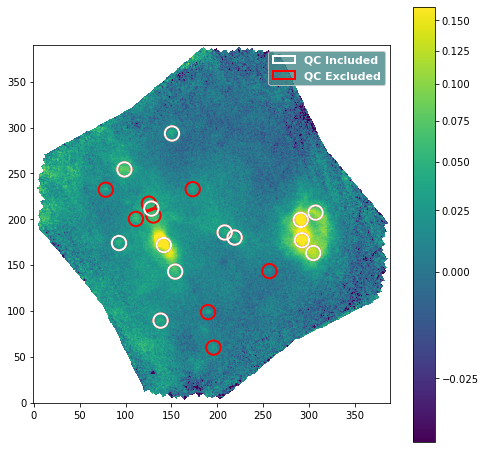

In [89]:
#now let's examine which sources didn't pass the cuts - overplot on the image to see if it looks first order reasonable

#get source coordinates for the snr cut table
cutsc=mtcut['sky_centroid'] 

#Compare which sources are included/excluded
source_aperture =SkyCircularAperture(cutsc, r=6*u.arcsec)

#convert to pixel coords for plotting
pix_aperture_source = source_aperture.to_pixel(wcsmap)


#show figure with apertures overlayed
plt.figure(figsize=(8,8))
norm = simple_norm(data, 'sqrt', percent=99)
plt.imshow(data, norm=norm, interpolation='nearest',origin='lower')
plt.colorbar()
#plt.xlim(40, 140)
#plt.ylim(50, 125)


ap_patches = pix_aperture.plot(color='red', lw=2,
                           label='QC Excluded')
ap_patches_new = pix_aperture_source.plot(color='white', lw=2,
                           label='QC Included')

handles = (ap_patches_new[0],ap_patches[0])
plt.legend(loc='best', facecolor='#458989', labelcolor='white',
          handles=handles, prop={'weight': 'bold', 'size': 11})
plt.show()

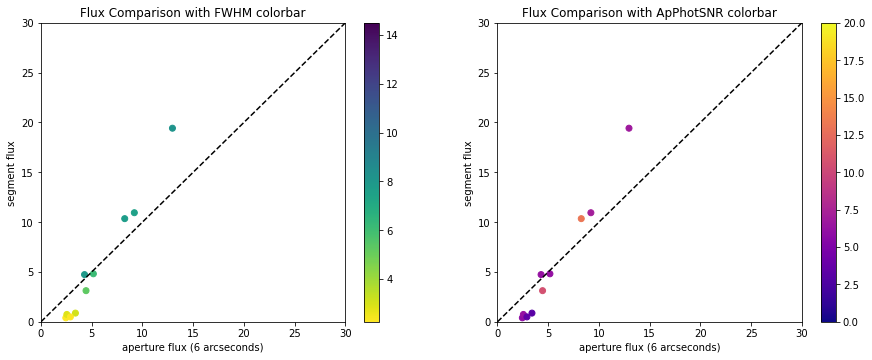

In [90]:
#a few diagnostic plots to examine segment and aperture fluxes
fig, (ax1,ax2) = plt.subplots(1, 2,figsize=(15,5.5))

ax1.set_title('Flux Comparison with FWHM colorbar')
p1=ax1.scatter(mtcut['aper_sum_bkgsub_6as'],mtcut['segment_flux'],c=mtcut['fwhm']*0.768, cmap='viridis_r')
fig.colorbar(p1, ax=ax1)
ax1.plot([0,30],[0,30],'k--')
ax1.set_xlabel('aperture flux (6 arcseconds)')
ax1.set_ylabel('segment flux')
ax1.set_xlim(0,30)
ax1.set_ylim(0,30)

ax2.set_title('Flux Comparison with ApPhotSNR colorbar')
p2=ax2.scatter(mtcut['aper_sum_bkgsub_6as'],mtcut['segment_flux'],c=mtcut['aper_snr_6as'], cmap='plasma',vmin=0,vmax=20)
fig.colorbar(p2, ax=ax2)
ax2.plot([0,30],[0,30],'k--')
ax2.set_xlabel('aperture flux (6 arcseconds)')
ax2.set_ylabel('segment flux')
ax2.set_xlim(0,30)
ax2.set_ylim(0,30)


plt.show()

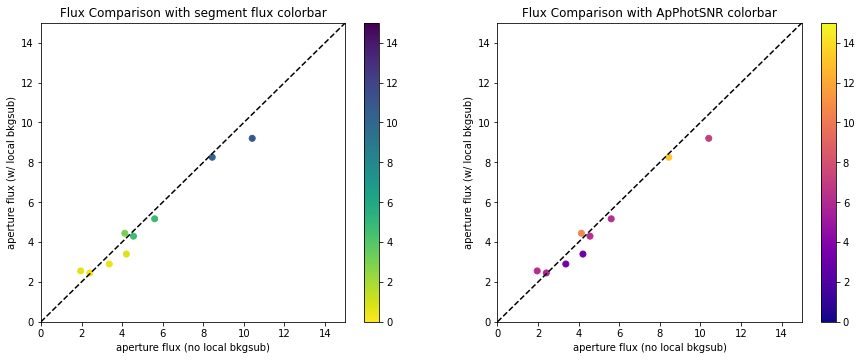

In [91]:
#a few diagnostic plots to examine background contributions to aperture flux
fig, (ax1,ax2) = plt.subplots(1, 2,figsize=(15,5.5))

ax1.set_title('Flux Comparison with segment flux colorbar')
p1=ax1.scatter(mtcut['aperture_sum_6as'],mtcut['aper_sum_bkgsub_6as'],c=mtcut['segment_flux'], cmap='viridis_r',vmin=0,vmax=15)
fig.colorbar(p1, ax=ax1)
ax1.plot([0,30],[0,30],'k--')
ax1.set_xlabel('aperture flux (no local bkgsub)')
ax1.set_ylabel('aperture flux (w/ local bkgsub)')
ax1.set_xlim(0,15)
ax1.set_ylim(0,15)

ax2.set_title('Flux Comparison with ApPhotSNR colorbar')
p2=ax2.scatter(mtcut['aperture_sum_6as'],mtcut['aper_sum_bkgsub_6as'],c=mtcut['aper_snr_6as'], cmap='plasma',vmin=0,vmax=15)
fig.colorbar(p2, ax=ax2)
ax2.plot([0,30],[0,30],'k--')
ax2.set_xlabel('aperture flux (no local bkgsub)')
ax2.set_ylabel('aperture flux (w/ local bkgsub)')
ax2.set_xlim(0,15)
ax2.set_ylim(0,15)


plt.show()

In [92]:
#write out the resulting table to file
ascii.write(mtcut, field+'_25um_cat_qcuts.dat', overwrite=True)